## Ingest to neo4j

In [ ]:
import pandas as pd
import json
from neo4j import GraphDatabase

# Neo4j connection config
NEO4J_URI = "neo4j://localhost:7687"
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = "password"

In [ ]:
with open("../data/companyDetailsByKodeEmiten.json", "r", encoding="utf-8") as f:
    stocks_profile = json.load(f)  # Make sure this returns a list of dicts

len(pd.read_json('..//data/companyDetailsByKodeEmiten.json').columns)

print(type(stocks_profile))         # should be <class 'list'>
# print(type(stocks_profile[0]))      # should be <class 'dict'>

In [ ]:
import re

def clean_indonesian_name(name):
    original_name = name
    # Define known titles, degrees, and honorifics (add more as needed)
    noise_tokens = {
        'dr', 'drs', 'h', 'ir', 'prof', 'kh', 'hj', 'hrh', 'mr', 'mrs', 'ms',  # prefixes
        'sh', 'mh', 'phd', 'spd', 'mpd', 'se', 'mm', 'msi', 'skom', 'st', 'mt', 'mkom', 'pm', 'bsc'  # suffixes
    }

    name = name.lower()
    name = re.sub(r'[^\w\s]', '', name)  # remove punctuation
    tokens = name.split()
    
    # Remove known titles and single-letter fragments (initials)
    tokens = [t for t in tokens if t not in noise_tokens and len(t) > 1]
    
    return original_name
    # return ' '.join(tokens)

# Example usage
names = [
    "Dr. M. Arsjad Rasjid PM BSC",
    "m arsjad rasjid pm",
    "MR. Joko Widodo, S.H., M.H.",
    "Ir. Sri Mulyani Indrawati, M.Si.",
    "Mrs. Megawati S. Soekarnoputri",
    "Hj. Tri Rismaharini"
]

cleaned = [clean_indonesian_name(n) for n in names]
for original, c in zip(names, cleaned):
    print(f"{original}  -->  {c}")


In [ ]:
# Cypher command to delete all data
cypher_query = "MATCH (n) DETACH DELETE n"

def delete_all_data():
    driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))
    with driver.session() as session:
        session.run(cypher_query)
    driver.close()
    print("All data deleted.")

delete_all_data()

In [ ]:
# Load JSON data
with open("../data/companyDetailsByKodeEmiten.json", "r", encoding="utf-8") as f:
    stocks_profile = dict(list(json.load(f).items())[:])

# Connect to Neo4j
driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

def ingest_stock(tx, stock):
    profile = stock['Profiles'][0]
    kode = profile["KodeEmiten"]

    # Create/Update Company node with enriched data
    tx.run("""
        MERGE (c:Company {kode: $kode})
        SET c.name = $kode,
            c.companyName = $name,
            c.industry = $industry,
            c.subIndustry = $sub_industry,
            c.sector = $sector,
            c.subSector = $sub_sector,
            c.website = $website,
            c.email = $email,
            c.phone = $telepon,
            c.fax = $fax,
            c.address = $alamat,
            c.npwp = $npwp,
            c.listingBoard = $papan,
            c.listingDate = date($tanggal_pencatatan),
            c.businessActivity = $kegiatan_usaha
    """, kode=kode,
         name=profile["NamaEmiten"],
         industry=profile["Industri"],
         sub_industry=profile.get("SubIndustri"),
         sector=profile["Sektor"],
         sub_sector=profile.get("SubSektor"),
         website=profile["Website"],
         email=profile.get("Email"),
         telepon=profile.get("Telepon"),
         fax=profile.get("Fax"),
         alamat=profile.get("Alamat"),
         npwp=profile.get("NPWP"),
         papan=profile.get("PapanPencatatan"),
         tanggal_pencatatan=profile.get("TanggalPencatatan", "")[:10],
         kegiatan_usaha=profile.get("KegiatanUsahaUtama")
    )

    # Directors
    for d in stock.get("Direktur", []):
        tx.run("""
            MERGE (d:Insider {name: $name})
            WITH d
            MATCH (c:Company {kode: $kode})
            MERGE (d)-[:DIRECTOR_OF {jabatan: $jabatan, afiliasi: $afiliasi}]->(c)
        """, name=clean_indonesian_name(d["Nama"]), jabatan=d["Jabatan"], afiliasi=d.get("Afiliasi", False), kode=stock['Profiles'][0]["KodeEmiten"])

    # Commissioners
    for k in stock.get("Komisaris", []):
        tx.run("""
            MERGE (k:Insider {name: $name})
            WITH k
            MATCH (c:Company {kode: $kode})
            MERGE (k)-[:COMMISSIONER_OF {jabatan: $jabatan, independen: $independen}]->(c)
        """, name=clean_indonesian_name(k["Nama"]), jabatan=k["Jabatan"], independen=k.get("Independen", False), kode=stock['Profiles'][0]["KodeEmiten"])

    # Corporate Secretary
    for s in stock.get("Sekretaris", []):
        tx.run("""
            MERGE (sec:Insider {name: $name})
            WITH sec
            MATCH (c:Company {kode: $kode})
            MERGE (sec)-[:CORPORATE_SECRETARY_OF {
                phone: $phone, email: $email, fax: $fax
            }]->(c)
        """, name=clean_indonesian_name(s["Nama"]),
             phone=s.get("Telepon"),
             email=s.get("Email"),
             fax=s.get("Fax"),
             kode=kode
        )

    # Audit Committee
    for a in stock.get("KomiteAudit", []):
        tx.run("""
            MERGE (ac:Insider {name: $name})
            WITH ac
            MATCH (c:Company {kode: $kode})
            MERGE (ac)-[:AUDIT_COMMITTEE_MEMBER_OF {jabatan: $jabatan}]->(c)
        """, name=clean_indonesian_name(a["Nama"]),
             jabatan=a["Jabatan"],
             kode=kode
        )

    # Shareholders
    for s in stock.get("PemegangSaham", []):
        tx.run("""
            MERGE (s:Insider {name: $name})
            WITH s
            MATCH (c:Company {kode: $kode})
            MERGE (s)-[:OWNS {jumlah: $jumlah, kategori: $kategori, pengendali: $pengendali, persentase: $persentase}]->(c)
        """,
            jumlah=s.get("Jumlah"),  
            kategori=s.get("Kategori"),
            name=clean_indonesian_name(s["Nama"]), 
            pengendali=s.get("Pengendali"),
            persentase=s.get("Persentase"),  
            kode=stock['Profiles'][0]["KodeEmiten"]
        )
    # Subsidiaries (AnakPerusahaan)
    for a in stock.get("AnakPerusahaan", []):
        tx.run("""
            MERGE (s:Subsidiary {name: $name})
            SET s.bidangUsaha = $bidang_usaha, s.lokasi = $lokasi, s.jumlahAset = $jumlah_aset,
                s.satuan = $satuan, s.statusOperasi = $status_operasi, s.tahunKomersil = $tahun_komersil,
                s.mataUang = $mata_uang
            WITH s
            MATCH (c:Company {kode: $kode})
            MERGE (s)-[:SUBSIDIARY_OF {persentase: $persentase}]->(c)
        """, name=a["Nama"], bidang_usaha=a["BidangUsaha"], lokasi=a["Lokasi"], jumlah_aset=a["JumlahAset"],
            satuan=a["Satuan"], status_operasi=a["StatusOperasi"], tahun_komersil=a["TahunKomersil"],
            mata_uang=a["MataUang"], persentase=a["Persentase"], kode=stock['Profiles'][0]["KodeEmiten"])

    # # Dividends (Dividen)
    # for d in stock.get("Dividen", []):
    #     tx.run("""
    #         MATCH (c:Company {kode: $kode})
    #         MERGE (div:Dividend {tahunBuku: $tahun_buku, jenis: $jenis})
    #         SET div.nama = $nama, div.totalSahamBonus = $total_saham_bonus, 
    #             div.cashDividenPerSaham = $cash_per_saham, div.cashDividenPerSahamMU = $cash_per_saham_mu,
    #             div.cashDividenTotal = $cash_total, div.cashDividenTotalMU = $cash_total_mu,
    #             div.tanggalCum = date($tanggal_cum), div.tanggalEx = date($tanggal_ex),
    #             div.tanggalDPS = datetime($tanggal_dps), div.tanggalPembayaran = date($tanggal_pembayaran),
    #             div.rasio1 = $rasio1, div.rasio2 = $rasio2
    #         MERGE (c)-[:PAID_DIVIDEND]->(div)
    #     """, kode=d["Nama"], nama=d["Nama"], jenis=d["Jenis"], tahun_buku=d["TahunBuku"],
    #         total_saham_bonus=d["TotalSahamBonus"], cash_per_saham=d["CashDividenPerSaham"],
    #         cash_per_saham_mu=d["CashDividenPerSahamMU"], cash_total=d["CashDividenTotal"],
    #         cash_total_mu=d["CashDividenTotalMU"], tanggal_cum=d["TanggalCum"][:10],
    #         tanggal_ex=d["TanggalExRegulerDanNegosiasi"][:10], tanggal_dps=d["TanggalDPS"],
    #         tanggal_pembayaran=d["TanggalPembayaran"][:10], rasio1=d["Rasio1"], rasio2=d["Rasio2"])

    # # Bonds and Sukuk
    # for b in stock.get("BondsAndSukuk", []):
    #     tx.run("""
    #         MERGE (bond:Bond {isin: $isin})
    #         SET bond.namaEmisi = $nama_emisi, bond.listingDate = date($listing_date),
    #             bond.matureDate = date($mature_date), bond.rating = $rating, bond.nominal = $nominal,
    #             bond.margin = $margin, bond.waliAmanat = $wali_amanat
    #         WITH bond
    #         MATCH (c:Company {kode: $kode})
    #         MERGE (c)-[:ISSUED]->(bond)
    #     """, isin=b["ISINCode"], nama_emisi=b["NamaEmisi"], listing_date=b["ListingDate"][:10],
    #         mature_date=b["MatureDate"][:10], rating=b["Rating"], nominal=b["Nominal"],
    #         margin=b["Margin"], wali_amanat=b["WaliAmanat"], kode=b["KodeEmiten"])

    # # Issued Bond Details
    # for i in stock.get("IssuedBond", []):
    #     tx.run("""
    #         MERGE (i:IssuedBond {id: $id})
    #         SET i.namaSeri = $nama_seri, i.amortisasiValue = $amortisasi_value,
    #             i.sinkingFund = $sinking_fund, i.couponDetail = $coupon_detail,
    #             i.couponPaymentDetail = date($coupon_payment_detail),
    #             i.matureDate = date($mature_date)
    #         WITH i
    #         MATCH (c:Company {kode: $kode})
    #         MERGE (c)-[:ISSUED_DETAIL]->(i)
    #     """, id=i["id"], nama_seri=i["NamaSeri"], amortisasi_value=i["AmortisasiValue"],
    #         sinking_fund=i["SinkingFund"], coupon_detail=i["CouponDetail"],
    #         coupon_payment_detail=i["CouponPaymentDetail"][:10],
    #         mature_date=i["MatureDate"][:10], kode=i["KodeEmiten"])

# Ingest all stocks_profile
with driver.session() as session:
    for ticker, stock_data in stocks_profile.items():
        # print(ticker, stock_data['Profiles'][0][0]["KodeEmiten"])
        session.execute_write(ingest_stock, stock_data) 

print("Ingestion complete.")
driver.close()


In [ ]:
with open("../data/companySummaryByKodeEmiten.json", "r", encoding="utf-8") as f:
    stocks_summary = json.load(f)['data']  # Make sure this returns a list of dicts

cypher_query = """
UNWIND $batch AS row
MERGE (c:Company {kode: row.StockCode})
MERGE (s:TradeDay {
    date: date(split(row.Date, "T")[0]),
    kode: row.StockCode
})
SET 
    s.name = toString(date(split(row.Date, "T")[0])) + "|" + row.StockCode,
    s.idstocksummary=row.IDStockSummary,
    s.stockname=row.StockName,
    s.remarks=row.Remarks,
    s.previous=row.Previous,
    s.openprice=row.OpenPrice,
    s.firsttrade=row.FirstTrade,
    s.high=row.High,
    s.low=row.Low,
    s.close=row.Close,
    s.change=row.Change,
    s.volume=row.Volume,
    s.value=row.Value,
    s.frequency=row.Frequency,
    s.indexindividual=row.IndexIndividual,
    s.offer=row.Offer,
    s.offervolume=row.OfferVolume,
    s.bid=row.Bid,
    s.bidvolume=row.BidVolume,
    s.listedshares=row.ListedShares,
    s.tradebleshares=row.TradebleShares,
    s.weightforindex=row.WeightForIndex,
    s.foreignsell=row.ForeignSell,
    s.foreignbuy=row.ForeignBuy,
    s.delistingdate=row.DelistingDate,
    s.nonregularvolume=row.NonRegularVolume,
    s.nonregularvalue=row.NonRegularValue,
    s.nonregularfrequency=row.NonRegularFrequency
MERGE (c)-[:HAS_TRADE_DAY]->(s)
"""

# Neo4j session
def insert_data(uri, user, password, data):
    driver = GraphDatabase.driver(uri, auth=(user, password))
    with driver.session() as session:
        session.execute_write(lambda tx: tx.run(cypher_query, batch=data))
    driver.close()

# Run ingestion
insert_data(NEO4J_URI, NEO4J_USER, NEO4J_PASSWORD, stocks_summary)
print("Stock summary data ingested successfully.")

## PSQL

In [ ]:
import pandas as pd
from sqlalchemy import create_engine

db_params = {
    "dbname": "postgres",
    "user": "postgres",
    "password": "postgres",
    "host": "localhost",  # Change to your database host
    "port": "5432"       # Change to your database port
}
db_url = f"postgresql://{db_params['user']}:{db_params['password']}@{db_params['host']}:{db_params['port']}/{db_params['dbname']}"
engine = create_engine(db_url)

In [ ]:
import json

with open("../data/response.json", "r", encoding="utf-8") as f:
    data = json.load(f)  # Make sure this returns a list of dicts

len(data['data'])

In [ ]:
df = pd.read_sql('select * from financial_ratios', engine)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
from psycopg2 import sql
from io import StringIO
import matplotlib.ticker as mtick

def get_indonesia_stocks_data(conn):
    """
    Get Indonesian stock data from PostgreSQL database
    """
    print("Fetching Indonesian stock data from PostgreSQL...")
    
    # Get the most recent data for each stock
    query = """
    WITH latest_fs AS (
        SELECT 
            code, 
            MAX(fs_date) as latest_date
        FROM 
            financial_ratios
        GROUP BY 
            code
    )
    SELECT 
        sf.sector, sf.sub_sector, sf.industry, sf.sub_industry, sf.code, sf.stock_name, sf.sharia, sf.fs_date, sf.fiscal_year_end, sf.assets, sf.liabilities, sf.equity, sf.sales, sf.ebt, sf.profit_period, sf.profit_attr_owner, sf.eps, sf.audit, sf.opini, sf.book_value, sf.per, sf.price_bv, sf.de_ratio, sf.roa, sf.roe, sf.npm
    FROM 
        financial_ratios sf
    JOIN 
        latest_fs lf ON sf.code = lf.code AND sf.fs_date = lf.latest_date
    ORDER BY 
        sf.sector, sf.sub_sector, sf.code
    """
    
    try:
        # Parse the sample data using pandas
        df = pd.read_sql(query, engine)
        
        # Get the latest financial data for each stock
        df = df.sort_values(['code', 'fs_date'], ascending=[True, False])
        df = df.drop_duplicates(subset=['code'], keep='first')
        
        # Make sure numeric columns are properly typed
        numeric_columns = ['assets', 'liabilities', 'equity', 'sales', 'ebt', 
                          'profit_period', 'profit_attr_owner', 'eps', 'book_value', 
                          'per', 'price_bv', 'de_ratio', 'roa', 'roe', 'npm']
        
        for col in numeric_columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

        # Buffett-style filtering
        df = df[
            (df['profit_attr_owner'] > 0) &
            (df['roe'] >= 15) &
            (df['de_ratio'] < 1) &
            (df['per'] > 0) &
            (df['price_bv'] > 0)
        ]

        # Sort by valuation (e.g., PER + PBV)
        df['buffett_score'] = df['per'].rank() + df['price_bv'].rank()
        df = df.sort_values(by='buffett_score')
            
        return df
        
    except Exception as e:
        print(f"Error fetching data: {e}")
        return pd.DataFrame()



        # Optional: Limit to top 10
        top_buffett_stocks = df.head(10).reset_index(drop=True)
        return top_buffett_stocks

def main():
    """
    Main function to identify potentially undervalued Indonesian stocks
    from PostgreSQL database
    """
    print("=== Indonesian Stock Value Analysis Tool ===")
    print("Disclaimer: This is for educational purposes only.")
    print("Always consult with a qualified financial advisor before making investment decisions.\n")
    
    # For a real implementation, use this to connect to your database:
    # conn = connect_to_postgres()
    # if conn is None:
    #     print("Failed to connect to database. Exiting.")
    #     return
    
    # Get Indonesian stock data
    # stocks_data = get_indonesia_stocks_data(conn)
    stocks_data = get_indonesia_stocks_data(None)  # Passing None since we're using sample data
    
    if stocks_data.empty:
        print("No stock data found. Exiting.")
        return
    
    return stocks_data
    
    
    
    # Close the database connection in a real implementation
    # if conn:
    #     conn.close()


df = main()

In [ ]:
df.sort_values(by='assets', ascending=False).head(10)

## yfinance

In [ ]:
import yfinance as yf
import pandas as pd
import time
from tqdm import tqdm

def get_idx_tickers():
    """
    Get a list of tickers from the Indonesia Stock Exchange (IDX)
    Indonesian stocks typically have .JK suffix on Yahoo Finance
    """
    # You could also use a more comprehensive list if you have one
    # This is a simplified approach that uses a common pattern for Indonesian stocks
    
    # Option 1: If you have a specific list of Indonesian stocks
    # For example, you could load from a file or define manually
    idx_tickers = [
        "BBCA.JK", "BBRI.JK", "BMRI.JK", "TLKM.JK", "ASII.JK",
        "UNVR.JK", "HMSP.JK", "BBNI.JK", "ICBP.JK", "KLBF.JK",
        # Add more tickers as needed
    ]
    
    # Option 2: You could try to scrape a more complete list
    # This would require additional code and potentially an external source
    
    return idx_tickers

def get_financial_ratios(ticker):
    """
    Get financial ratios for a given ticker
    """
    try:
        # Create a ticker object
        stock = yf.Ticker(ticker)
        
        # Get basic info and financial ratios
        info = stock.info
        
        # Extract key financial ratios
        ratios = {
            'Symbol': ticker,
            'Name': info.get('longName', ''),
            'Sector': info.get('sector', ''),
            'Industry': info.get('industry', ''),
            
            # Valuation Ratios
            'Market Cap': info.get('marketCap', None),
            'P/E Ratio': info.get('trailingPE', None),
            'Forward P/E': info.get('forwardPE', None),
            'PEG Ratio': info.get('pegRatio', None),
            'Price/Sales': info.get('priceToSalesTrailing12Months', None),
            'Price/Book': info.get('priceToBook', None),
            'Enterprise Value/EBITDA': info.get('enterpriseToEbitda', None),
            'Enterprise Value/Revenue': info.get('enterpriseToRevenue', None),
            
            # Profitability Ratios
            'Profit Margin': info.get('profitMargins', None),
            'Operating Margin': info.get('operatingMargins', None),
            'Return on Assets': info.get('returnOnAssets', None),
            'Return on Equity': info.get('returnOnEquity', None),
            
            # Dividend Ratios
            'Dividend Yield': info.get('dividendYield', None),
            'Dividend Rate': info.get('dividendRate', None),
            'Payout Ratio': info.get('payoutRatio', None),
            
            # Financial Health
            'Current Ratio': info.get('currentRatio', None),
            'Quick Ratio': info.get('quickRatio', None),
            'Debt to Equity': info.get('debtToEquity', None),
            
            # Growth Metrics
            'Earnings Growth': info.get('earningsGrowth', None),
            'Revenue Growth': info.get('revenueGrowth', None),
        }
        
        return ratios
    
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return {'Symbol': ticker, 'Error': str(e)}

def main():
    # Get list of Indonesian stock tickers
    idx_tickers = get_idx_tickers()
    print(f"Found {len(idx_tickers)} Indonesian stocks to analyze")
    
    # Collect financial ratios for all tickers
    all_ratios = []
    
    for ticker in tqdm(idx_tickers, desc="Fetching financial ratios"):
        ratios = get_financial_ratios(ticker)
        all_ratios.append(ratios)
        
        # Add a small delay to avoid hitting rate limits
        time.sleep(0.5)
    
    # Convert to DataFrame
    df = pd.DataFrame(all_ratios)
    
    # Save to CSV
    output_file = "indonesia_stock_financial_ratios.csv"
    df.to_csv(output_file, index=False)
    print(f"Financial ratios saved to {output_file}")
    
    # Display the first few rows
    print("\nSample of financial ratios:")
    print(df.head())
    
    return df


main()

In [ ]:
import yfinance as yf
import pandas as pd
import time
from tqdm import tqdm

def get_idx_tickers():
    """
    Get a list of tickers from the Indonesia Stock Exchange (IDX)
    Indonesian stocks typically have .JK suffix on Yahoo Finance
    """
    # You could also use a more comprehensive list if you have one
    # This is a simplified approach that uses a common pattern for Indonesian stocks
    idx_tickers = [
        "BBCA.JK", "BBRI.JK", "BMRI.JK", "TLKM.JK", "ASII.JK",
        "UNVR.JK", "HMSP.JK", "BBNI.JK", "ICBP.JK", "KLBF.JK",
        # Add more tickers as needed
    ]
    
    return idx_tickers

def get_stock_holders(ticker):
    """
    Get major holders and institutional holders for a given ticker
    """
    try:
        # Create a ticker object
        stock = yf.Ticker(ticker)
        
        # Get basic info
        info = stock.info
        
        # Get major holders data
        major_holders_df = pd.DataFrame()
        try:
            major_holders = stock.major_holders
            if major_holders is not None and not major_holders.empty:
                major_holders_df = major_holders.rename(columns={0: 'Value', 1: 'Description'})
        except Exception as e:
            print(f"Error fetching major holders for {ticker}: {e}")
        
        # Get institutional holders data
        institutional_holders_df = pd.DataFrame()
        try:
            institutional_holders = stock.institutional_holders
            if institutional_holders is not None and not institutional_holders.empty:
                institutional_holders_df = institutional_holders
        except Exception as e:
            print(f"Error fetching institutional holders for {ticker}: {e}")
        
        # Get mutual fund holders data
        mutualfund_holders_df = pd.DataFrame()
        try:
            mutualfund_holders = stock.mutualfund_holders
            if mutualfund_holders is not None and not mutualfund_holders.empty:
                mutualfund_holders_df = mutualfund_holders
        except Exception as e:
            print(f"Error fetching mutual fund holders for {ticker}: {e}")
            
        return {
            'symbol': ticker,
            'name': info.get('longName', ''),
            'major_holders': major_holders_df,
            'institutional_holders': institutional_holders_df,
            'mutualfund_holders': mutualfund_holders_df
        }
        
    except Exception as e:
        print(f"Error processing {ticker}: {e}")
        return {'symbol': ticker, 'error': str(e)}

def get_stock_insiders(ticker):
    """
    Get insider trading data for a given ticker
    """
    try:
        # Create a ticker object
        stock = yf.Ticker(ticker)
        
        # Get basic info
        info = stock.info
        
        # Get insider trading data
        insider_trades_df = pd.DataFrame()
        try:
            insider_trades = stock.insider_transactions
            if insider_trades is not None and not insider_trades.empty:
                insider_trades_df = insider_trades
        except Exception as e:
            print(f"Error fetching insider trades for {ticker}: {e}")
        
        # Get insider roster data
        insider_roster_df = pd.DataFrame()
        try:
            insider_roster = stock.insider_roster
            if insider_roster is not None and not insider_roster.empty:
                insider_roster_df = insider_roster
        except Exception as e:
            print(f"Error fetching insider roster for {ticker}: {e}")
            
        return {
            'symbol': ticker,
            'name': info.get('longName', ''),
            'insider_trades': insider_trades_df,
            'insider_roster': insider_roster_df
        }
        
    except Exception as e:
        print(f"Error processing {ticker}: {e}")
        return {'symbol': ticker, 'error': str(e)}

def save_holders_data(holders_data, output_dir="."):
    """
    Save holders data to CSV files
    """
    all_major_holders = []
    all_institutional_holders = []
    all_mutualfund_holders = []
    
    for data in holders_data:
        symbol = data['symbol']
        name = data.get('name', '')
        
        # Process major holders
        if 'major_holders' in data and not data['major_holders'].empty:
            df = data['major_holders'].copy()
            df['Symbol'] = symbol
            df['Name'] = name
            all_major_holders.append(df)
        
        # Process institutional holders
        if 'institutional_holders' in data and not data['institutional_holders'].empty:
            df = data['institutional_holders'].copy()
            df['Symbol'] = symbol
            df['Name'] = name
            all_institutional_holders.append(df)
        
        # Process mutual fund holders
        if 'mutualfund_holders' in data and not data['mutualfund_holders'].empty:
            df = data['mutualfund_holders'].copy()
            df['Symbol'] = symbol
            df['Name'] = name
            all_mutualfund_holders.append(df)
    
    # Save to CSV files
    if all_major_holders:
        major_holders_df = pd.concat(all_major_holders, ignore_index=True)
        major_holders_df.to_csv(f"{output_dir}/indonesia_major_holders.csv", index=False)
        print(f"Major holders data saved to indonesia_major_holders.csv")
    
    if all_institutional_holders:
        inst_holders_df = pd.concat(all_institutional_holders, ignore_index=True)
        inst_holders_df.to_csv(f"{output_dir}/indonesia_institutional_holders.csv", index=False)
        print(f"Institutional holders data saved to indonesia_institutional_holders.csv")
    
    if all_mutualfund_holders:
        fund_holders_df = pd.concat(all_mutualfund_holders, ignore_index=True)
        fund_holders_df.to_csv(f"{output_dir}/indonesia_mutualfund_holders.csv", index=False)
        print(f"Mutual fund holders data saved to indonesia_mutualfund_holders.csv")

def save_insiders_data(insiders_data, output_dir="."):
    """
    Save insiders data to CSV files
    """
    all_insider_trades = []
    all_insider_roster = []
    
    for data in insiders_data:
        symbol = data['symbol']
        name = data.get('name', '')
        
        # Process insider trades
        if 'insider_trades' in data and not data['insider_trades'].empty:
            df = data['insider_trades'].copy()
            df['Symbol'] = symbol
            df['Name'] = name
            all_insider_trades.append(df)
        
        # Process insider roster
        if 'insider_roster' in data and not data['insider_roster'].empty:
            df = data['insider_roster'].copy()
            df['Symbol'] = symbol
            df['Name'] = name
            all_insider_roster.append(df)
    
    # Save to CSV files
    if all_insider_trades:
        insider_trades_df = pd.concat(all_insider_trades, ignore_index=True)
        insider_trades_df.to_csv(f"{output_dir}/indonesia_insider_trades.csv", index=False)
        print(f"Insider trades data saved to indonesia_insider_trades.csv")
    
    if all_insider_roster:
        insider_roster_df = pd.concat(all_insider_roster, ignore_index=True)
        insider_roster_df.to_csv(f"{output_dir}/indonesia_insider_roster.csv", index=False)
        print(f"Insider roster data saved to indonesia_insider_roster.csv")

def main():
    # Get list of Indonesian stock tickers
    idx_tickers = get_idx_tickers()
    print(f"Found {len(idx_tickers)} Indonesian stocks to analyze")
    
    # Collect holders data for all tickers
    holders_data = []
    insiders_data = []
    
    for ticker in tqdm(idx_tickers, desc="Fetching holders and insiders data"):
        # Get holders data
        holder_info = get_stock_holders(ticker)
        holders_data.append(holder_info)
        
        # Get insiders data
        insider_info = get_stock_insiders(ticker)
        insiders_data.append(insider_info)
        
        # Add a small delay to avoid hitting rate limits
        time.sleep(1)
    
    # Save data to CSV files
    save_holders_data(holders_data)
    save_insiders_data(insiders_data)
    
    print("Data collection complete!")

if __name__ == "__main__":
    main()

## Cypher 

In [ ]:
"""
MATCH (c:Company)-[]-(i:Insider)
WHERE toLower(i.name) CONTAINS 'lo kheng hong'
RETURN c, i

MATCH (i:Insider)
WHERE toLower(i.name) CONTAINS 'prajogo pangestu'
MATCH (i)-[r1:OWNS|DIRECTOR_OF|COMMISSIONER_OF]->(c:Company)
OPTIONAL MATCH (s:Subsidiary)-[r2:SUBSIDIARY_OF]->(c)
RETURN DISTINCT i, r1, c, r2, s

// Delete all StockSummary nodes and their relationships
MATCH (s:TradeDay)<-[r:HAS_TRADE_DAY]-()
DELETE r, s;

MATCH (n)
UNWIND labels(n) AS label
UNWIND keys(n) AS key
RETURN label, collect(DISTINCT key) AS properties
ORDER BY label;


MATCH ()-[r]->()
WITH type(r) AS relType, keys(r) AS keysList
UNWIND keysList AS key
RETURN relType, collect(DISTINCT key) AS properties
ORDER BY relType;

MATCH (i:Insider)-[owns:OWNS]->(c:Company)-[:HAS_TRADE_DAY]->(td:TradeDay)
WITH i, owns.jumlah AS sharesOwned, c, td
WITH i, c, sharesOwned, td.close AS latestClosePrice
WITH i, sum(sharesOwned * latestClosePrice) AS totalValue
where totalValue > 0 and  not (i.name CONTAINS 'masyarakat') and not (i.name CONTAINS 'pt ') and not (i.name CONTAINS ' ltd') 
and not (i.name CONTAINS ' limited') and not (i.name CONTAINS ' pt') and not (i.name CONTAINS ' bv') and not (i.name CONTAINS 'saham') and not (i.name CONTAINS 'pengendali')
RETURN i.name AS InsiderName, totalValue
ORDER BY totalValue DESC
"""


In [35]:
import pandas as pd

df = pd.read_json(r"C:\Users\muhammad.amal\Downloads\neo4j_query_table_data_2025-5-19.json")
df

,InsiderName,totalValue
0,dato low tuck kwong,270532090954000
1,prajogo pangestu,176605739570400
2,elaine low,148143440740000
3,otto toto sugiri,112905128952000
4,marina budiman,84982415601600
...,...,...
2169,pemerintah ri,2652
2170,tee teddy setiawan,2436
2171,anthony setiadi,1490
2172,dra maria goretti tinawati,1490


C:\Users\muhammad.amal\AppData\Local\Temp\ipykernel_1696\2742339232.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


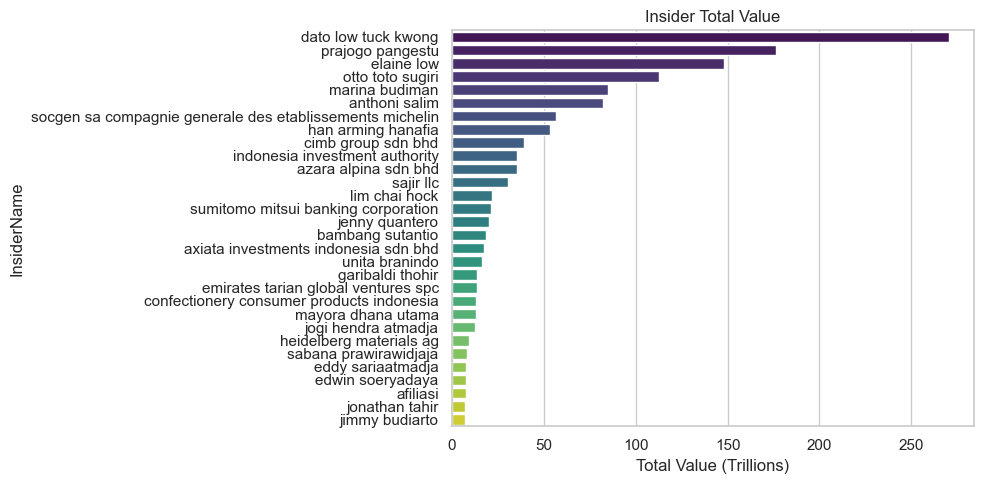

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sort by value for visual clarity
df = df.sort_values('totalValue', ascending=False).head(30)

df['totalValue'] = df['totalValue'] / 1e12

# Set the style
sns.set(style="whitegrid")

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(
    x='totalValue',
    y='InsiderName',
    data=df,
    palette='viridis'
)

plt.title('Insider Total Value')
plt.xlabel('Total Value (Trillions)')
plt.tight_layout()
plt.show()